In [3]:
%matplotlib inline
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import stats
import itertools

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

#labels
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)
eventLabel=pd.DataFrame()
eventLabel['eventidx']=dfAll.index
eventLabel['valence']=dfAll['valence'].map(lambda x: 1 if x >0 else 0)
eventLabel['arousal']=dfAll['arousal'].map(lambda x: 1 if x >1 else 0)
eventLabel.set_index('eventidx',inplace=True)

eventLabel['event']=dfAll['event']

eventdf=pd.get_dummies(dfAll.event)
emodf=pd.get_dummies(dfAll.emotions)

eventLabel=pd.concat([eventLabel,emodf],axis=1)
eventLabel.head()

,valence,arousal,event,colere,ennui,fierte,frustration,joie,neutre,peur
eventidx,,,,,,,,,,
0,0,1,rate,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,arret du gardien,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,but,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,tir,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,arret du gardien,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
dfAll.head()

,sujet,match,Absolute_sec,event,emotions,arousal,valence
0,1,1,47637,rate,frustration,2.0,-1.0
1,1,1,47813,arret du gardien,colere,2.0,-1.0
2,1,1,47852,but,colere,2.0,-3.0
3,1,1,48157,tir,peur,1.0,-1.0
4,1,2,49632,arret du gardien,frustration,2.0,-2.0


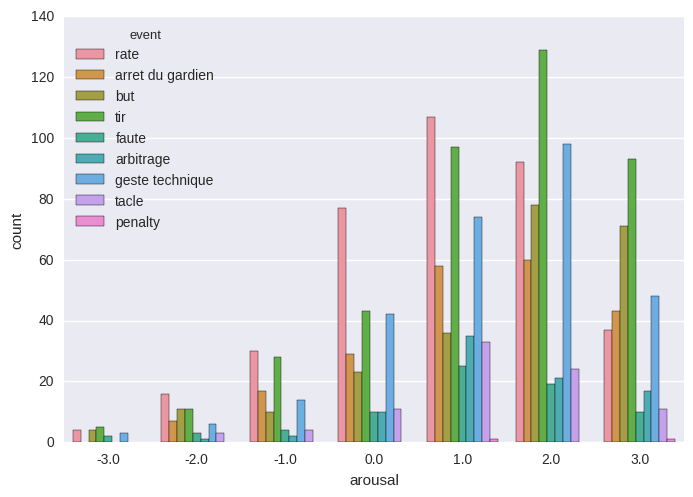

In [5]:
ax = sns.countplot(x="arousal", hue="event",data=dfAll)

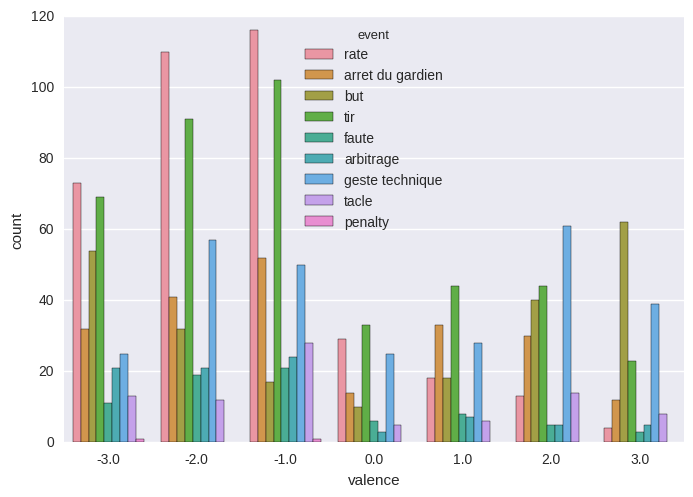

In [6]:
ax = sns.countplot(x="valence", hue="event",data=dfAll)

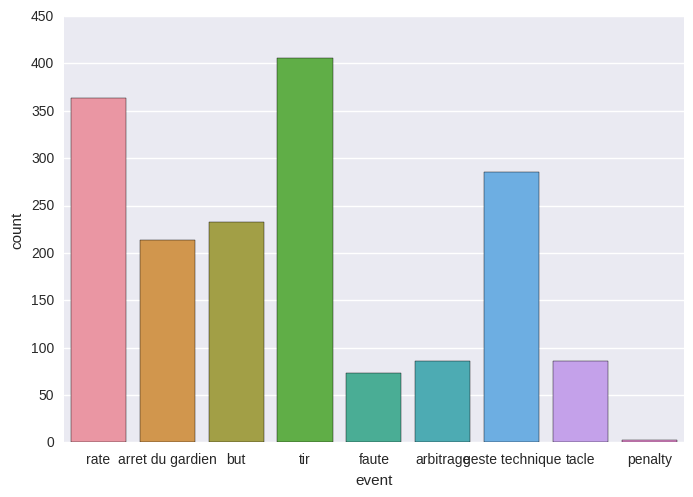

In [7]:
ax = sns.countplot(x="event", data=dfAll)

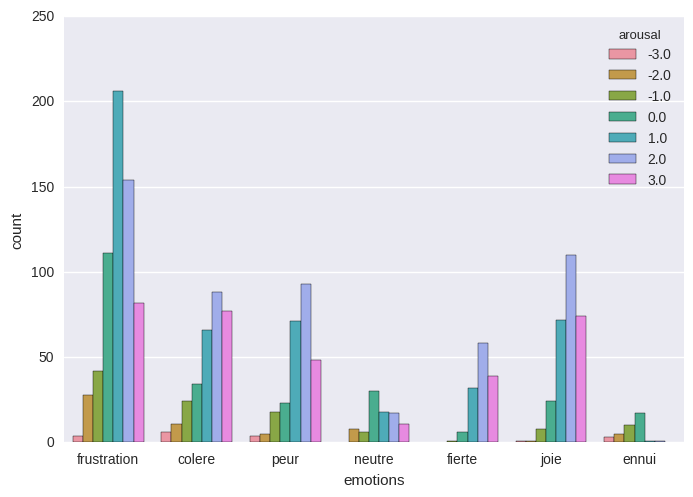

In [8]:
ax = sns.countplot(x="emotions", hue="arousal",data=dfAll)

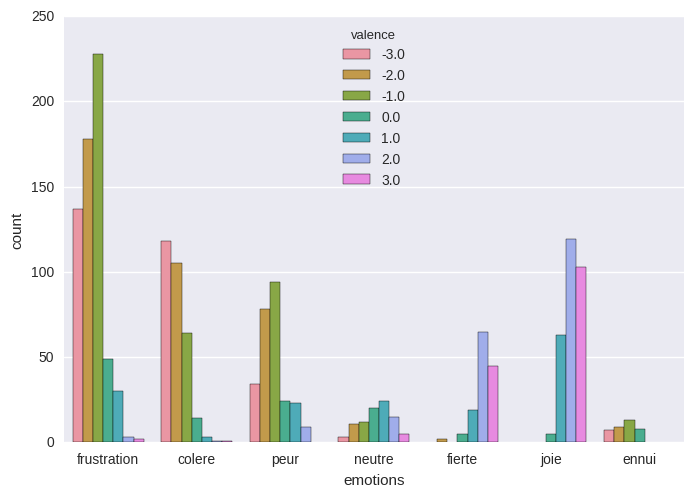

In [9]:
ax = sns.countplot(x="emotions", hue="valence",data=dfAll)

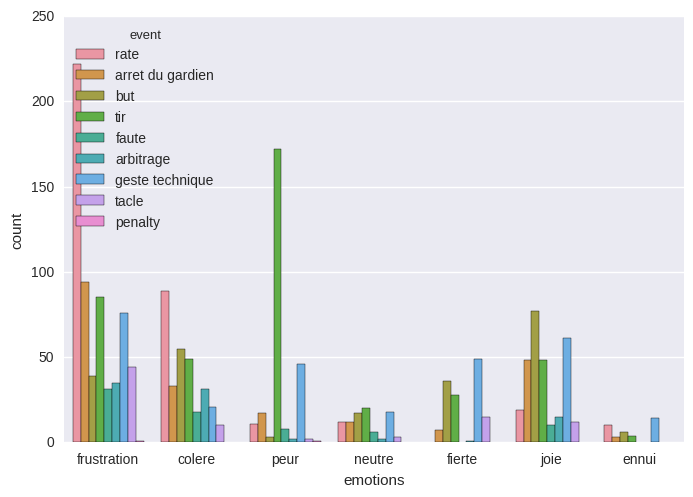

In [10]:
ax = sns.countplot(x="emotions", hue="event",data=dfAll)

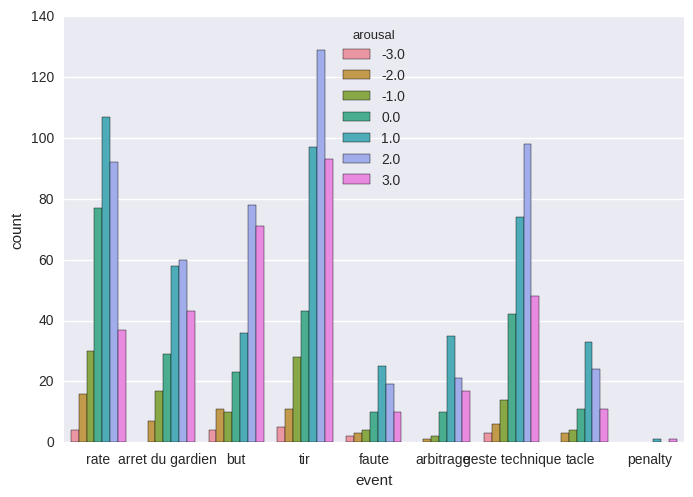

In [11]:
ax = sns.countplot(x="event", hue="arousal",data=dfAll)

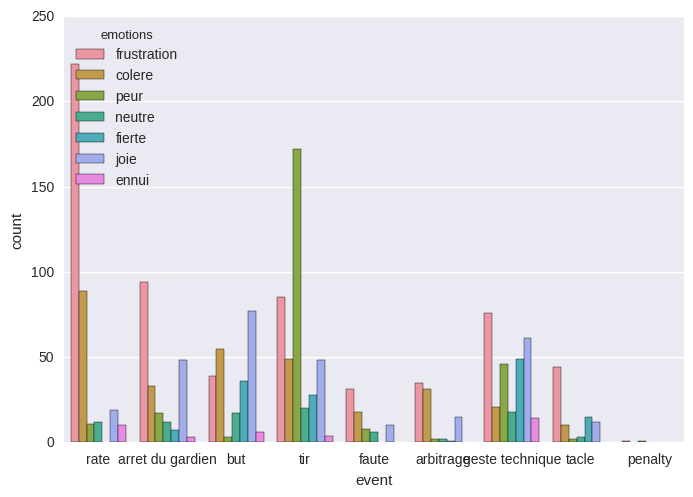

In [12]:
ax = sns.countplot(x="event", hue="emotions",data=dfAll)

In [13]:
#remove scare events
dfMajevent=dfAll[~dfAll['event'].isin(['faute','tacle','penalty','arbitrage'])]
#change fierte to joie
dfMajevent.loc[dfMajevent['emotions']=='fierte','emotions']='joie'
# arret du gardian => arret
dfMajevent.loc[dfMajevent['event']=='arret du gardien','event']='arret'
# geste technique => geste
dfMajevent.loc[dfMajevent['event']=='geste technique','event']='geste'
#remove emotion: ennnui,neutre
dfMajevent=dfMajevent[~dfMajevent['emotions'].isin(['ennui','neutre'])]

dfMajevent.head()

/local/wenlu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,sujet,match,Absolute_sec,event,emotions,arousal,valence
0,1,1,47637,rate,frustration,2.0,-1.0
1,1,1,47813,arret,colere,2.0,-1.0
2,1,1,47852,but,colere,2.0,-3.0
3,1,1,48157,tir,peur,1.0,-1.0
4,1,2,49632,arret,frustration,2.0,-2.0


In [14]:
#add pour & contre
def pour(row):
    if row['valence']>0:
        return row['event']+'_pour'
    else:
        return row['event']+'_contre'
    
dfMajevent['event']=dfMajevent.apply(pour,axis=1)

In [15]:
dfMajevent.loc[dfMajevent['emotions']=='fierte','emotions']='joie'

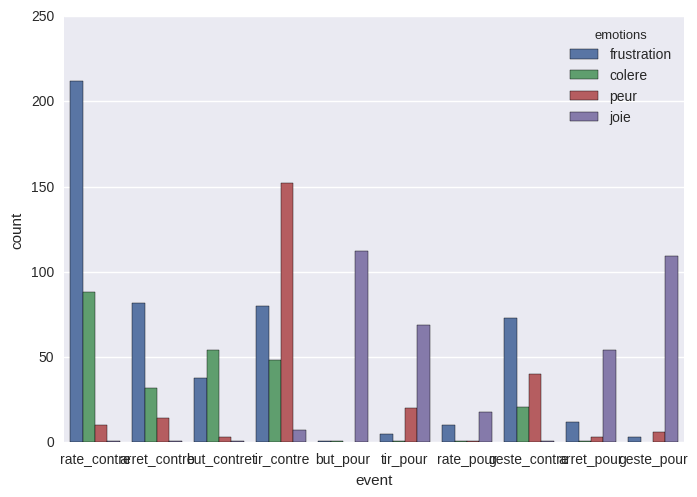

In [16]:
ax = sns.countplot(x="event", hue="emotions",data=dfMajevent)

In [17]:
np.sum(dfMajevent.groupby(['sujet'])['event'].count()>30)

16

In [18]:
grouped=dfMajevent.groupby(['sujet','match'])
for name, df in grouped:
    print(name)
    print ([row['event'] for index, row in df.iterrows()])
    print ([row['emotions'] for index, row in df.iterrows()])

(1, 1)
[u'rate_contre', 'arret_contre', u'but_contre', u'tir_contre']
[u'frustration', u'colere', u'colere', u'peur']
(1, 2)
['arret_contre', u'tir_contre', u'rate_contre', u'but_contre', u'rate_contre']
[u'frustration', u'peur', u'frustration', u'colere', u'frustration']
(1, 3)
[u'but_contre', u'tir_contre', u'tir_contre', u'but_pour', 'arret_contre', u'rate_contre', u'rate_contre']
[u'peur', u'peur', u'peur', 'joie', u'peur', u'colere', u'frustration']
(2, 1)
['arret_contre', u'tir_pour', u'rate_contre', u'rate_contre', u'tir_contre', u'rate_contre', 'arret_contre', u'rate_pour']
[u'frustration', u'peur', u'frustration', u'frustration', u'frustration', u'frustration', u'colere', u'peur']
(2, 2)
[u'rate_contre', u'rate_contre', u'rate_contre', u'tir_contre', u'rate_contre', 'geste_contre', u'tir_contre', 'arret_pour', u'tir_pour', 'geste_contre', u'rate_contre', u'tir_contre', u'rate_contre', u'but_contre', u'rate_contre']
[u'frustration', u'frustration', u'frustration', u'peur', u'fr

In [34]:
def event2int(row):
    events={'rate_contre':0,
           'arret_contre':1,
           'geste_contre':2,
            'but_contre':3,
            'tir_contre':4,
            'rate_pour':5,
            'arret_pour':6,
            'geste_pour':7,
            'but_pour':8,
            'tir_pour':9}
    return events[row['event']]

def emo2int(row):
    emotions={'frustration':0,'peur':1,'colere':2,'joie':3}
    return emotions[row['emotions']]

dfMajevent['eventidx']=dfMajevent.apply(lambda row:event2int(row),axis=1)
dfMajevent['emoidx']=dfMajevent.apply(lambda row:emo2int(row),axis=1)
dfMajevent.head()

,sujet,match,Absolute_sec,event,emotions,arousal,valence,eventidx,emoidx
0,1,1,47637,rate_contre,frustration,2.0,-1.0,0,0
1,1,1,47813,arret_contre,colere,2.0,-1.0,1,2
2,1,1,47852,but_contre,colere,2.0,-3.0,3,2
3,1,1,48157,tir_contre,peur,1.0,-1.0,4,1
4,1,2,49632,arret_contre,frustration,2.0,-2.0,1,0


In [48]:
succ=dfMajevent.iloc[:,[0,1,7,8]]
succevent=np.array(succ['eventidx'])[1:]
succemo=np.array(succ['emoidx'])[1:]
succ=succ.drop([1747])
succ['eventsucc']=succevent
succ['emosucc']=succemo  
succ.tail()

,sujet,match,eventidx,emoidx,eventsucc,emosucc
1740,58,3,3,2,1,2
1741,58,3,1,2,3,2
1742,58,3,3,2,0,0
1744,58,3,0,0,3,2
1746,58,3,3,2,6,3


In [131]:
dictseq={}
for ids, seqs in succ.groupby(['sujet','match']):
    dictseq[ids]=np.array(seqs['eventidx'])
dictemo={}
for ids, seqs in succ.groupby(['sujet','match']):
    dictemo[ids]=np.array(seqs['emoidx'])

In [132]:
dictemo[(28,2)]

array([0, 3, 3, 0, 2, 2, 2, 0, 3, 3])

In [119]:
len(dictseq)

170

In [137]:
tmp=succ.groupby(['emoidx','eventidx'])['match'].count().reset_index()
tmp1=tmp.set_index(['emoidx','eventidx']).unstack().fillna(0)
B0=np.array(tmp1)
B=B0/np.sum(B0,axis=1).reshape(4,1)
B

array([[ 0.41085271,  0.15891473,  0.14147287,  0.07364341,  0.15503876,
         0.01937984,  0.02325581,  0.00581395,  0.00193798,  0.00968992],
       [ 0.04016064,  0.0562249 ,  0.16064257,  0.01204819,  0.61044177,
         0.00401606,  0.01204819,  0.02409639,  0.        ,  0.08032129],
       [ 0.3562753 ,  0.12955466,  0.08502024,  0.21862348,  0.19433198,
         0.00404858,  0.00404858,  0.        ,  0.00404858,  0.00404858],
       [ 0.00268817,  0.00268817,  0.00268817,  0.00268817,  0.0188172 ,
         0.0483871 ,  0.14247312,  0.29301075,  0.30107527,  0.18548387]])

In [62]:
tmp=(succ.groupby(['sujet','match']).emoidx.first().reset_index())
Counter(tmp['emoidx'])

Counter({0: 71, 1: 39, 2: 18, 3: 42})

In [138]:
A=[[184,101,100,131],
   [88,57,31,73],
   [96,39,63,49],
   [147,52,53,120]]
An=np.array(A,dtype='float16')/np.sum(np.array(A),axis=1).reshape(4,1)
An

array([[ 0.35658915,  0.19573643,  0.19379845,  0.25387597],
       [ 0.35341365,  0.22891566,  0.12449799,  0.29317269],
       [ 0.38866397,  0.15789474,  0.25506073,  0.19838057],
       [ 0.39516129,  0.13978495,  0.14247312,  0.32258065]])

In [59]:
Counter([(row['emoidx'],row['emosucc']) for i,row in succ.iterrows()])

Counter({(0, 0): 184,
         (0, 1): 101,
         (0, 2): 100,
         (0, 3): 131,
         (1, 0): 88,
         (1, 1): 57,
         (1, 2): 31,
         (1, 3): 73,
         (2, 0): 96,
         (2, 1): 39,
         (2, 2): 63,
         (2, 3): 49,
         (3, 0): 147,
         (3, 1): 52,
         (3, 2): 53,
         (3, 3): 120})

In [58]:
from collections import Counter
Counter([(row['eventidx'],row['eventsucc']) for i,row in succ.iterrows()])

Counter({(0, 0): 92,
         (0, 1): 19,
         (0, 2): 27,
         (0, 3): 27,
         (0, 4): 61,
         (0, 5): 5,
         (0, 6): 18,
         (0, 7): 24,
         (0, 8): 20,
         (0, 9): 18,
         (1, 0): 24,
         (1, 1): 19,
         (1, 2): 15,
         (1, 3): 9,
         (1, 4): 30,
         (1, 5): 4,
         (1, 6): 1,
         (1, 7): 12,
         (1, 8): 7,
         (1, 9): 8,
         (2, 0): 21,
         (2, 1): 8,
         (2, 2): 18,
         (2, 3): 11,
         (2, 4): 33,
         (2, 5): 2,
         (2, 6): 12,
         (2, 7): 15,
         (2, 8): 5,
         (2, 9): 10,
         (3, 0): 30,
         (3, 1): 5,
         (3, 2): 9,
         (3, 3): 9,
         (3, 4): 21,
         (3, 6): 7,
         (3, 7): 4,
         (3, 8): 7,
         (3, 9): 4,
         (4, 0): 57,
         (4, 1): 26,
         (4, 2): 34,
         (4, 3): 21,
         (4, 4): 63,
         (4, 5): 5,
         (4, 6): 15,
         (4, 7): 24,
         (4, 8): 24,
         

In [57]:
for i in succ.iterrows():
    print i

(0, sujet        1
match        1
eventidx     0
emoidx       0
eventsucc    1
emosucc      2
Name: 0, dtype: int64)
(1, sujet        1
match        1
eventidx     1
emoidx       2
eventsucc    3
emosucc      2
Name: 1, dtype: int64)
(2, sujet        1
match        1
eventidx     3
emoidx       2
eventsucc    4
emosucc      1
Name: 2, dtype: int64)
(3, sujet        1
match        1
eventidx     4
emoidx       1
eventsucc    1
emosucc      0
Name: 3, dtype: int64)
(4, sujet        1
match        2
eventidx     1
emoidx       0
eventsucc    4
emosucc      1
Name: 4, dtype: int64)
(5, sujet        1
match        2
eventidx     4
emoidx       1
eventsucc    0
emosucc      0
Name: 5, dtype: int64)
(6, sujet        1
match        2
eventidx     0
emoidx       0
eventsucc    3
emosucc      2
Name: 6, dtype: int64)
(8, sujet        1
match        2
eventidx     3
emoidx       2
eventsucc    0
emosucc      0
Name: 8, dtype: int64)
(9, sujet        1
match        2
eventidx     0
emoidx       0


In [156]:
from ghmm import *

#emotion = IntergerRange(1,5)
#event = emotion = IntergerRange(1,11)
sigma= IntegerRange(0,10)
A = An
pi=[71./170,39./170,18./170,42./170]
m = HMMFromMatrices(sigma, DiscreteDistribution(sigma), A, B, pi)
print m

DiscreteEmissionHMM(N=4, M=10)
  state 0 (initial=0.42)
    Emissions: 0.41, 0.16, 0.14, 0.07, 0.16, 0.02, 0.02, 0.01, 0.00, 0.01
    Transitions: ->0 (0.36), ->1 (0.20), ->2 (0.19), ->3 (0.25)
  state 1 (initial=0.23)
    Emissions: 0.04, 0.06, 0.16, 0.01, 0.61, 0.00, 0.01, 0.02, 0.00, 0.08
    Transitions: ->0 (0.35), ->1 (0.23), ->2 (0.12), ->3 (0.29)
  state 2 (initial=0.11)
    Emissions: 0.36, 0.13, 0.09, 0.22, 0.19, 0.00, 0.00, 0.00, 0.00, 0.00
    Transitions: ->0 (0.39), ->1 (0.16), ->2 (0.26), ->3 (0.20)
  state 3 (initial=0.25)
    Emissions: 0.00, 0.00, 0.00, 0.00, 0.02, 0.05, 0.14, 0.29, 0.30, 0.19
    Transitions: ->0 (0.40), ->1 (0.14), ->2 (0.14), ->3 (0.32)



In [157]:
alph = IntegerRange(0,10)
train_seq = EmissionSequence(alph, [0, 9, 6, 0, 4, 0, 0, 4, 9, 8] )
m.baumWelch(train_seq)
v = m.viterbi(test_seq)
print v

([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)


In [158]:
alph = IntegerRange(0,10)
test_seq=EmissionSequence(alph,train_seqs[102]) # 28,2  [0, 9, 6, 0, 4, 0, 0, 4, 9, 8] =>emoarray([0, 3, 3, 0, 2, 2, 2, 0, 3, 3])
for i in range(50,100):
    train_seq = EmissionSequence(alph, train_seqs[i] )
    m.baumWelch(train_seq)
    v = m.viterbi(test_seq)
    print v
    #[0, 1, 2, 0, 1, 2, 0, 1, 3, 3]

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - foba.c:ghmm_dmodel_forward(199): scale smaller than epsilon (0 < 1e-08) in position 1. Can't generate symbol 1

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - foba.c:ghmm_dmodel_forward(199): scale smaller than epsilon (0 < 1e-08) in position 1. Can't generate symbol 2

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817): reestimate_one_step false (1.step)

GHMM ghmm.py:148 - reestimate.c:ghmm_dmodel_baum_welch(817)

([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.591674093408319)
([0, 1, 2, 0, 1, 2, 0, 1, 3, 3], -6.5916740934

In [139]:
train_seqs=[None]*170
j=0
for i, seq in dictseq.iteritems():
    print(i,j,list(seq))
    train_seqs[j]=list(seq)
    j=j+1

((7, 3), 0, [8, 4, 4, 0, 3])
((40, 3), 1, [0, 0, 3, 0, 3, 6, 2, 3, 9, 2, 5])
((12, 1), 2, [4, 7, 0, 4, 0, 0, 5, 5])
((41, 2), 3, [4, 3])
((38, 1), 4, [0, 2, 0])
((43, 3), 5, [1, 9, 2, 4, 8, 8, 7, 8, 3])
((15, 1), 6, [7, 2, 3, 9, 5, 4])
((48, 1), 7, [2, 3, 4, 4, 4, 0, 0, 4, 4, 7])
((25, 1), 8, [2, 4, 8, 3, 4, 0, 8])
((46, 3), 9, [1, 4, 3, 1, 4])
((27, 2), 10, [4, 1, 9, 4, 9, 9, 8, 2, 4, 4])
((51, 1), 11, [4, 2, 9, 7, 6, 4])
((32, 2), 12, [3, 8, 0, 4, 1, 8])
((33, 3), 13, [3, 1, 2, 7, 2, 6, 4, 4, 2])
((16, 3), 14, [1, 1, 0, 0, 4, 2, 8, 8, 8])
((17, 2), 15, [7, 3, 0, 7, 8, 0, 4, 0, 1])
((14, 1), 16, [2, 1])
((38, 2), 17, [1, 4, 4, 1, 2])
((19, 3), 18, [4, 7, 9, 2, 6, 1, 7])
((24, 1), 19, [0, 0, 7, 9, 1, 9, 1, 7, 0, 7, 0, 0])
((1, 1), 20, [0, 1, 3, 4])
((50, 1), 21, [3, 0, 6, 8, 9, 1])
((22, 3), 22, [4, 9, 0, 4, 4, 4, 2, 4, 9, 1, 0, 7, 1])
((3, 2), 23, [7, 4, 7, 4, 4, 0, 7, 0, 4, 4, 0, 0, 4, 4])
((27, 1), 24, [4, 8, 9, 7, 0, 2, 2, 9, 6, 2])
((8, 2), 25, [3, 6, 3, 3, 0])
((53, 1), 26, [4, 2

In [281]:
from hmmlearn.hmm import MultinomialHMM
dictseq={};dictemo={}
for ids, seqs in succ.groupby(['sujet','match']):
    dictseq[ids]=np.array(seqs['eventidx'])
    dictemo[ids]=np.array(seqs['emoidx'])
    print (ids)
    print (dictseq[ids])
    print (dictemo[ids])
    
#train 
num=100
X= [[j] for j in list(np.concatenate([list(dictseq[i]) for i in dictseq.keys()[:num]]))]
lengths=[len(dictseq[i]) for i in dictseq.keys()[:num]]
model=MultinomialHMM(n_components=4, startprob_prior=np.array(pi), transmat_prior=An, algorithm='viterbi', random_state=None, n_iter=10, tol=0.01, verbose=False, params='ste', init_params='ste').fit(X,lengths)
model.emissionprob_ =B
#test
res=np.zeros((170,2))
for i in range(0,170):
    test_seq= np.array([[j] for j in dictseq[dictseq.keys()[i]]])
    length=np.array([len(test_seq)])
    prob,pred=model.decode(test_seq,length)
    real=dictemo[dictseq.keys()[i]]
    score=np.sum(real==pred)*1.0/len(real)
    #print (dictseq.keys()[i])
    #print (test_seq)
    #print (pred)
    #print len(real)
    res[i,:]=(len(real),score)
    print ('len=%d score=%.2f'%(len(real),score))

len=5 score=1.00
len=11 score=0.36
len=8 score=0.75
len=2 score=1.00
len=3 score=0.33
len=9 score=0.56
len=6 score=0.67
len=10 score=0.50
len=7 score=0.71
len=5 score=0.60
len=10 score=0.80
len=6 score=0.67
len=6 score=0.83
len=9 score=0.67
len=9 score=0.78
len=9 score=0.89
len=2 score=0.50
len=5 score=0.80
len=7 score=0.86
len=12 score=0.58
len=4 score=0.75
len=6 score=0.33
len=13 score=0.46
len=14 score=0.93
len=10 score=0.60
len=5 score=0.80
len=10 score=0.50
len=7 score=0.14
len=6 score=0.83
len=9 score=0.89
len=11 score=0.55
len=5 score=0.60
len=6 score=1.00
len=11 score=0.82
len=6 score=0.17
len=4 score=0.50
len=13 score=0.85
len=8 score=0.50
len=7 score=0.71
len=8 score=0.62
len=13 score=0.62
len=11 score=0.64
len=13 score=0.69
len=6 score=0.67
len=13 score=0.85
len=8 score=0.50
len=12 score=0.67
len=8 score=0.75
len=2 score=1.00
len=12 score=0.42
len=5 score=0.60
len=9 score=0.67
len=11 score=0.64
len=10 score=0.40
len=5 score=0.60
len=5 score=0.80
len=13 score=0.46
len=8 score

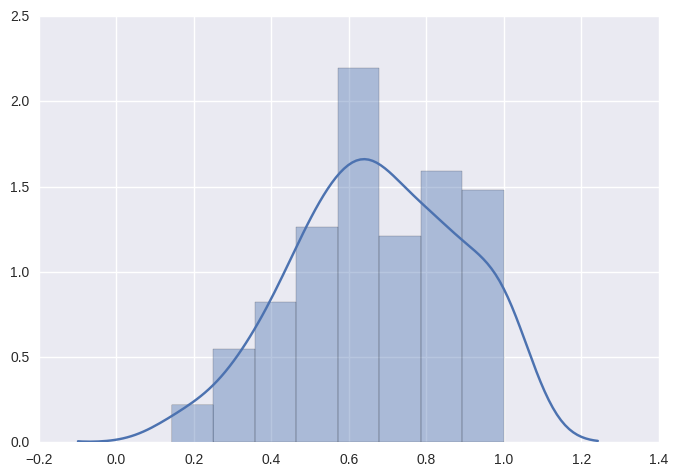

In [282]:
import seaborn as sns, numpy as np
ax = sns.distplot(res[:,1])

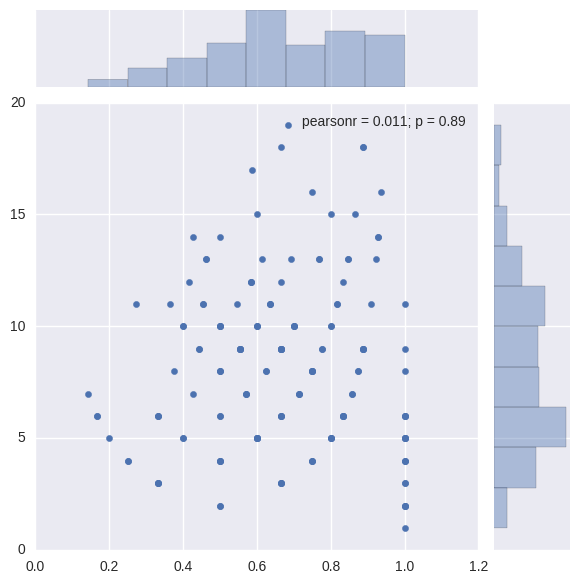

In [283]:
g = sns.jointplot(x=res[:,1], y=res[:,0])